In [1]:
# imports & their global configs

import os
import sys
import warnings
warnings.filterwarnings("ignore", message="Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.")

import utilities
import datanalysis as da

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np



In [2]:
# set global vars + ipynb imports        
CWPATH = '.'
DATA_SUFFIX = '.csv' # Assume any CSV is correct data

# find other folders
MOD_DIR = utilities.findSubmoduleDir(CWPATH)
PROJ_DIR = os.path.abspath(MOD_DIR + '/..')
sys.path.insert(0, MOD_DIR+'/notebooks')

from ipynb.fs.full.data_processing import (
    is_abnormal_cxr,
    open_data, #This is being overridden
    SYMPTOMS,
    VITALS,
    COMORBIDITIES,
)

In [3]:
# read data- i want to use the one supplied but need custom path + reset_index must be true
df = utilities.open_data(MOD_DIR + '/data')

In [4]:
# Let's drop some columns we know we're not interested in.
# We're using cxr_label + cxr_impression
df = df.drop([
'test_name',
'swab_type',
'cxr_link',
'cxr_findings',
'er_referral',
], axis='columns', errors='ignore')


In [5]:
df.apply(da.printDataTypeAnalaysis, axis='index', result_type="reduce")

,batch_date,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_impression,cxr_label
missing/empty,0,0,0,169,1501,0,0,0,0,0,0,0,0,4627,4644,4618,4618,5407,4783,11004,11083,5293,4146,6658,6344,7596,15,9507,2532,206,10220,187,176,183,190,190,187,182,183,10716,10716
Has NaNs,False,False,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
inferred type,object,object,<class 'numpy.number'>,object,object,bool,bool,bool,bool,bool,bool,bool,bool,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,object,object,object,object,object,object,<class 'numpy.number'>,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
"min,max",N/A,N/A,"(-3,90)",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,"(34.95,39.4)","(40.0,150.0)","(75.0,235.0)","(36.0,135.0)","(10.0,32.0)","(76.0,100.0)",N/A,N/A,N/A,N/A,N/A,N/A,"(1.0,300.0)",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
n uniques,11,2,N/A,2,2,2,2,2,2,2,2,2,2,N/A,N/A,N/A,N/A,N/A,N/A,2,2,2,2,2,2,N/A,2,3,2,2,3,2,2,2,2,2,2,2,2,189,3


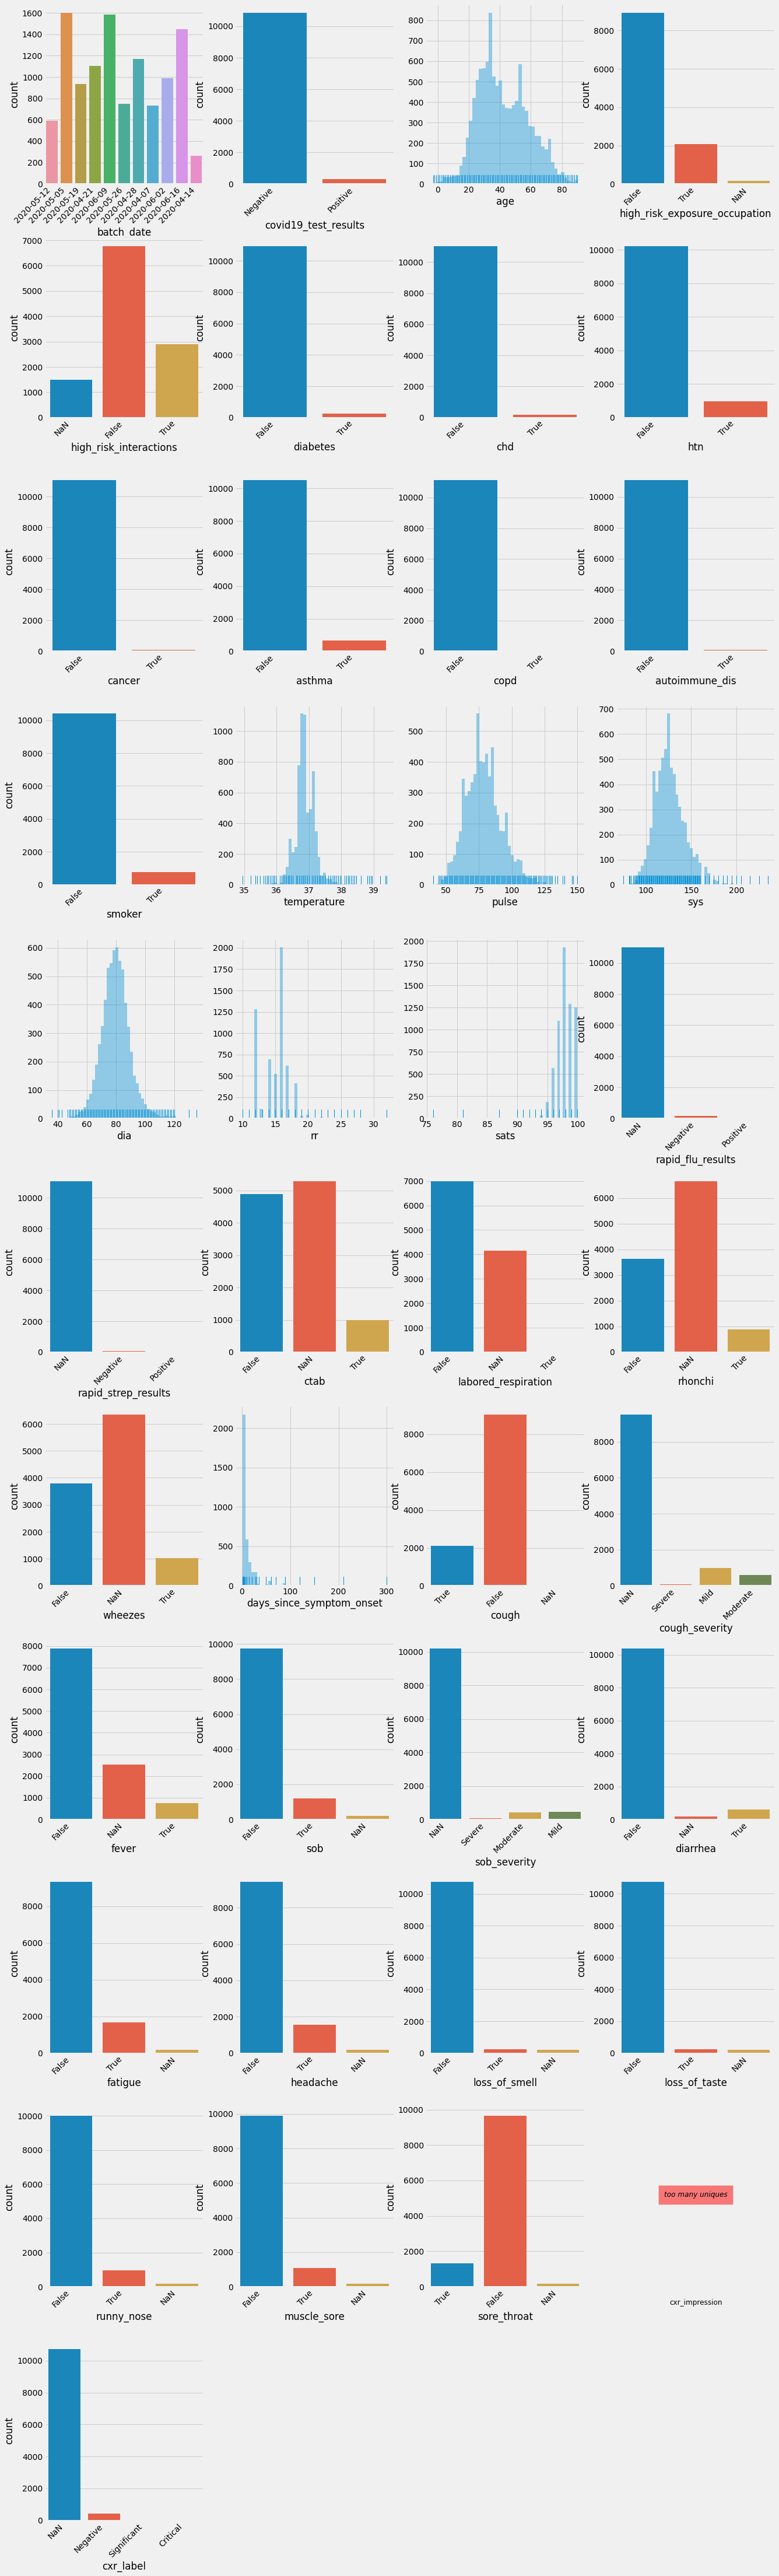

In [6]:
da.plotDataDistributions(df)

# Preprocessing:

We've already dropped some columns. We'll state policies here for 

* adding in missing values
* converting as much as possible to numbers (everything will be normalized 0-1)
* bounding data to be sane
* simplifying

## By Column

* batch_date

Convert this to a date, where 0 is the earliest and 1 is the latest.
* covid19_test_results

This should be "Positive" (1) or "Negative" (0)
* age

This should be abouve 0, and should be present.
If no age data, throw the data point out entirely.

* high_risk_exposure_occupation

This should be assumed False (and may be combined with high_risk_interactions)

* high_risk_interactions

This should be assumed False (and may be combined with high_risk_exposure_occupation)

* diabetes

Assumed false

* chd

Assumed false

* htn

Assumed false

* cancer

Assumed false

* asthma

Assumed false

* copd

Assumed false

* autoimmune_dis

Assumed false

* smoker

Assumed false

## Signs/Vitals

If no signs or vitals are present, we can assume that the clinicians assessed by patient presentation that the vitals were relatively normal, and we will fill in values as such. The other solution would be to present outliar values, and all non-present vitals would become their own cluster. We need to be reasonable in what values we accept, but that is **TODO**.

* temperature

* pulse

* sys

* dia

* rr

* sats

* rapid_flu_results

Rapid flu results should be assumed negative (clinician saw no reason to order), and can be combined with rapid_strep_results to form "counter_indication".

* rapid_strep_results

Rapid strep results should be assumed negative (clinician saw now reason to order), and can be combined with rapid_flu_results to form "counter_indication" category.

* ctab

Ctab should probably be droped since it's already described by the following three categories:

* labored

Assumed false.

* rhonchi

Assumed false.

* wheezes

Assumed false.

* days_since

This needs to be checked for reasonable bounds. It can be normalized easily.

## Symptoms

One solution is to combine all symptoms into a severity score, as done by data_processing.ipynb.

* cough

Cough and cough_severity are really part of the same data.

* cough_severity

Cough and cough_severity are really part of the same data.

* fever

Fever may be the same as temperature unless it has passed?

* sob

Sob and sob_severity are really part of the same data.

* sob_severity

Sob and sob_severity are really part of the same data.

* diarrhea

Diarrhea is binary.

* fatigue

Fatigue is binary.

* headache

Headache is binary.

* loss_of_smell

Loss_of_smell is binary.

* loss_of_taste

Loss_of_taste is binary.

* runny_nose

Runny_nose is binary.

* muscle_sore

Muscle_sore is binary.

* sore_throat

Soure_throat is binary.

* cxr_label

Cxr_labels should map to a severity number but shoudl assumed to be None.

* er_referral

This has been always false.

In [7]:

def numerize(column: pd.Series)-> pd.Series:
    low = column.min()
    width = column.max() - low
    if width == 0:
        return column
    return (column - low)/width

#Fix batch_date
if not np.issubdtype(df['batch_date'].infer_objects().dtypes, np.number):
    df['batch_date'] = pd.to_datetime(df['batch_date'])

#Fix covid19_test_results
if not np.issubdtype(df['covid19_test_results'].infer_objects().dtypes, np.number):
    df['covid19_test_results'].replace({
        'Negative': 0,
        'Positive': 1,
        }, inplace=True)

#Fix age- create new column for numerized since we use it below
if (any(df['age'] < 0)):
    df = df[df['age'] >= 0]
    df.reset_index(inplace=True) #reset_index seems to effect the listcomps

#Fix High-Risk
if 'high_risk_exposure_occupation' in df and 'high_risk_interactions' in df:
    # check the types here
    def hr(occupations: pd.Series, interactions: pd.Series) -> int:
        if occupations == True or interactions == True:
            return 1
        if occupations == False or interactions == False:
            return 0
        else:
            return None

    combinedRiskColumn = pd.Series([ hr(occupations, interactions) for occupations, interactions in zip(df['high_risk_exposure_occupation'], df['high_risk_interactions']) ])
    # You now have four options to deal with missing values

    # Assume high-risk
    combinedRiskColumn.fillna(1, inplace=True)
    # Assume low-risk
    #combinedRiskColumn.fillna(0, inplace=True)

    # Drop rows with missing values
    #df = df[combinedRiskColumn.notna()]
    #combinedRiskColumn.dropna(inplace=True)
    #df.reset_index(inplace=True)
    # still need to add column as below

    # Or just drop the whole column by not executing the lime below, maybe based on a threshhold `if combinedRiskColumn.isna().sum() > N`
    df['high_risk_combined'] = combinedRiskColumn

    df = df.drop([
    'high_risk_exposure_occupation',
    'high_risk_interactions'
    ], axis='columns', errors='ignore')

# Check comorbidities- assume false.
for col in COMORBIDITIES:
    df[col].fillna(False, inplace=True) 
    df[col].replace({
        False: 0,
        True: 1,
        }, inplace=True)

# LUT of typical vitals
def typicalTemp(age: int, temperature: float) -> float:
    if not np.isnan(temperature):
        return temperature
    if age < 18:
        return 36.9
    if age < 65:
        return 36.5
    return 36.2

df['temperature'] = pd.Series([ typicalTemp(age, temperature) for age, temperature in zip(df['age'], df['temperature']) ])

def typicalPulse(age: int, pulse: float) -> float:
    if not np.isnan(pulse):
        return pulse
    if age < 1:
        return 120
    if age < 2:
        return 110
    if age < 6:
        return 95
    if age < 12:
        return 90
    if age < 18:
        return 80
    return 70

df['pulse'] = pd.Series([ typicalPulse(age, pulse) for age, pulse in zip(df['age'], df['pulse']) ])

def typicalSys(age: int, sys: float) -> float:
    if not np.isnan(sys):
        return sys
    if age < 2:
        return 100
    if age < 10:
        return 105
    if age < 29:
        return 120
    if age < 35:
        return 122
    if age < 39:
        return 123
    if age < 45:
        return 124
    if age < 49:
        return 130
    return 134

df['sys'] = pd.Series([ typicalSys(age, sys) for age, sys in zip(df['age'], df['sys']) ])

def typicalDia(age: int, dia: float) -> float:
    if not np.isnan(dia):
        return dia
    if age < 2:
        return 50
    if age < 10:
        return 68
    if age < 29:
        return 75
    if age < 35:
        return 80
    if age < 39:
        return 82
    if age < 45:
        return 83
    if age < 49:
        return 84
    return 85

df['dia'] = pd.Series([ typicalDia(age, dia) for age, dia in zip(df['age'], df['dia']) ])

def typicalRR(age: int, rr: float) -> float:
    if not np.isnan(rr):
        return rr
    if age < 1:
        return 35
    if age < 3:
        return 25
    if age < 6:
        return 22
    if age < 10:
        return 20
    if age < 65:
        return 15
    if age < 80:
        return 18
    return 20

df['rr'] = pd.Series([ typicalRR(age, rr) for age, rr in zip(df['age'], df['rr']) ])

def typicalSATS(age: int, sats: float) -> float:
    if not np.isnan(sats):
        return sats
    if age < 18:
        return 98
    if age < 70:
        return 97
    return 95

df['sats'] = pd.Series([ typicalSATS(age, sats) for age, sats in zip(df['age'], df['sats']) ])

#Fix Counter-Indicators
if 'rapid_flu_results' in df and 'rapid_strep_results' in df:
    # check the types here
    def ci(flu: pd.Series, strep: pd.Series) -> int:
        if flu == "Positive" or strep == "Positive":
            return 1
        else:
            return 0

    counter_indicator = pd.Series([ ci(flu, strep) for flu, strep in zip(df['rapid_flu_results'], df['rapid_strep_results']) ])
    df['counter_indicator'] = counter_indicator

    df = df.drop([
    'rapid_flu_results',
    'rapid_strep_results'
    ], axis='columns', errors='ignore')

# Fix Lung Sounds
# This is a bit weird because the three conditions are similiar indicators, and kind of redundant with ctab, which means "no problem"
# (clear to auscultation bilaterally)
if 'ctab' in df:
    # check the types here
    def fix_ctab(ctab: pd.Series, labored_respiration: pd.Series, rhonchi: pd.Series, wheezes: pd.Series) -> int:
        if ctab == False or labored_respiration == True or rhonchi == True or wheezes == True:
            if ctab == True:
                # Weird, but common in this data? Cannot be true if any ethers are true
                pass
            return 0
        return 1

    df['ctab'] = pd.Series([ fix_ctab(ctab, labored_respiration, rhonchi, wheezes) 
                            for ctab, labored_respiration, rhonchi, wheezes 
                            in zip(df['ctab'], df['labored_respiration'], df['rhonchi'], df['wheezes']) ])
    
    for col in ["labored_respiration", "rhonchi", "wheezes"]:
        df[col].fillna(False, inplace=True) 
        df[col].replace({
            False: 0,
            True: 1,
            }, inplace=True)

# Fix Symptoms (combine doubles into one)
# fever*diarrhea	fatigue	headache	loss_of_smell	loss_of_taste	runny_nose	muscle_sore	sore_throat
for col in ["diarrhea", "fever", "headache", "fatigue", "loss_of_smell", "loss_of_taste", "runny_nose", "muscle_sore", "sore_throat"]:
    df[col].fillna(False, inplace=True) 
    df[col].replace({
        False: 0,
        True: 1,
        }, inplace=True)
        
if 'sob' in df:
    # check the types here
    def fix_sob(sob: pd.Series, sob_severity: pd.Series) -> int:
        if sob != True and type(sob_severity) == float:
            return 0
        if sob_severity == "Severe":
            return 3
        if sob_severity == "Moderate":
            return 2
        if sob_severity == "Mild":
            return 1
        if sob == True:
            return 2
        print("Shit")
    
    df['sob_severity'] = pd.Series([ fix_sob(sob, sob_severity) 
                            for sob, sob_severity 
                            in zip(df['sob'], df['sob_severity']) ])
    df = df.drop([
    'sob',
    ], axis='columns', errors='ignore')

if 'cough' in df:
    # check the types here
    def fix_cough(cough: pd.Series, cough_severity: pd.Series) -> int:
        if cough != True and type(cough_severity) == float:
            return 0
        if cough_severity == "Severe":
            return 3
        if cough_severity == "Moderate":
            return 2
        if cough_severity == "Mild":
            return 1
        if cough == True:
            return 2


    df['cough_severity'] = pd.Series([ fix_cough(cough, cough_severity) 
                            for cough, cough_severity 
                            in zip(df['cough'], df['cough_severity']) ])
    df = df.drop([
    'cough',
    ], axis='columns', errors='ignore')

if 'cxr_impression' in df:
    # check the types here
    def fix_cxr(imp: pd.Series, label: pd.Series) -> int:
        if label == "Significant":
            return 1
        if label == "Critical":
            return 2
        if type(imp) != str:
            return 0
        if is_abnormal_cxr(imp) == True:
            return 1
        return 0

    df['cxr_label'] = pd.Series([ fix_cxr(imp, label) 
                            for imp, label 
                            in zip(df['cxr_impression'], df['cxr_label']) ])
    df = df.drop([
    'cxr_impression',
    ], axis='columns', errors='ignore')

# :-/ This data is incomplete, we should probably get rid of this column instead of using the mean. 

df['days_since_symptom_onset'].fillna(df['days_since_symptom_onset'].mean(), inplace=True)

df = df.apply(numerize, axis='index')

In [8]:
df.apply(da.printDataTypeAnalaysis, axis='index', result_type="reduce")

,index,batch_date,covid19_test_results,age,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough_severity,fever,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_label,high_risk_combined,counter_indicator
missing/empty,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Has NaNs,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
inferred type,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>
"min,max","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)"
n uniques,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


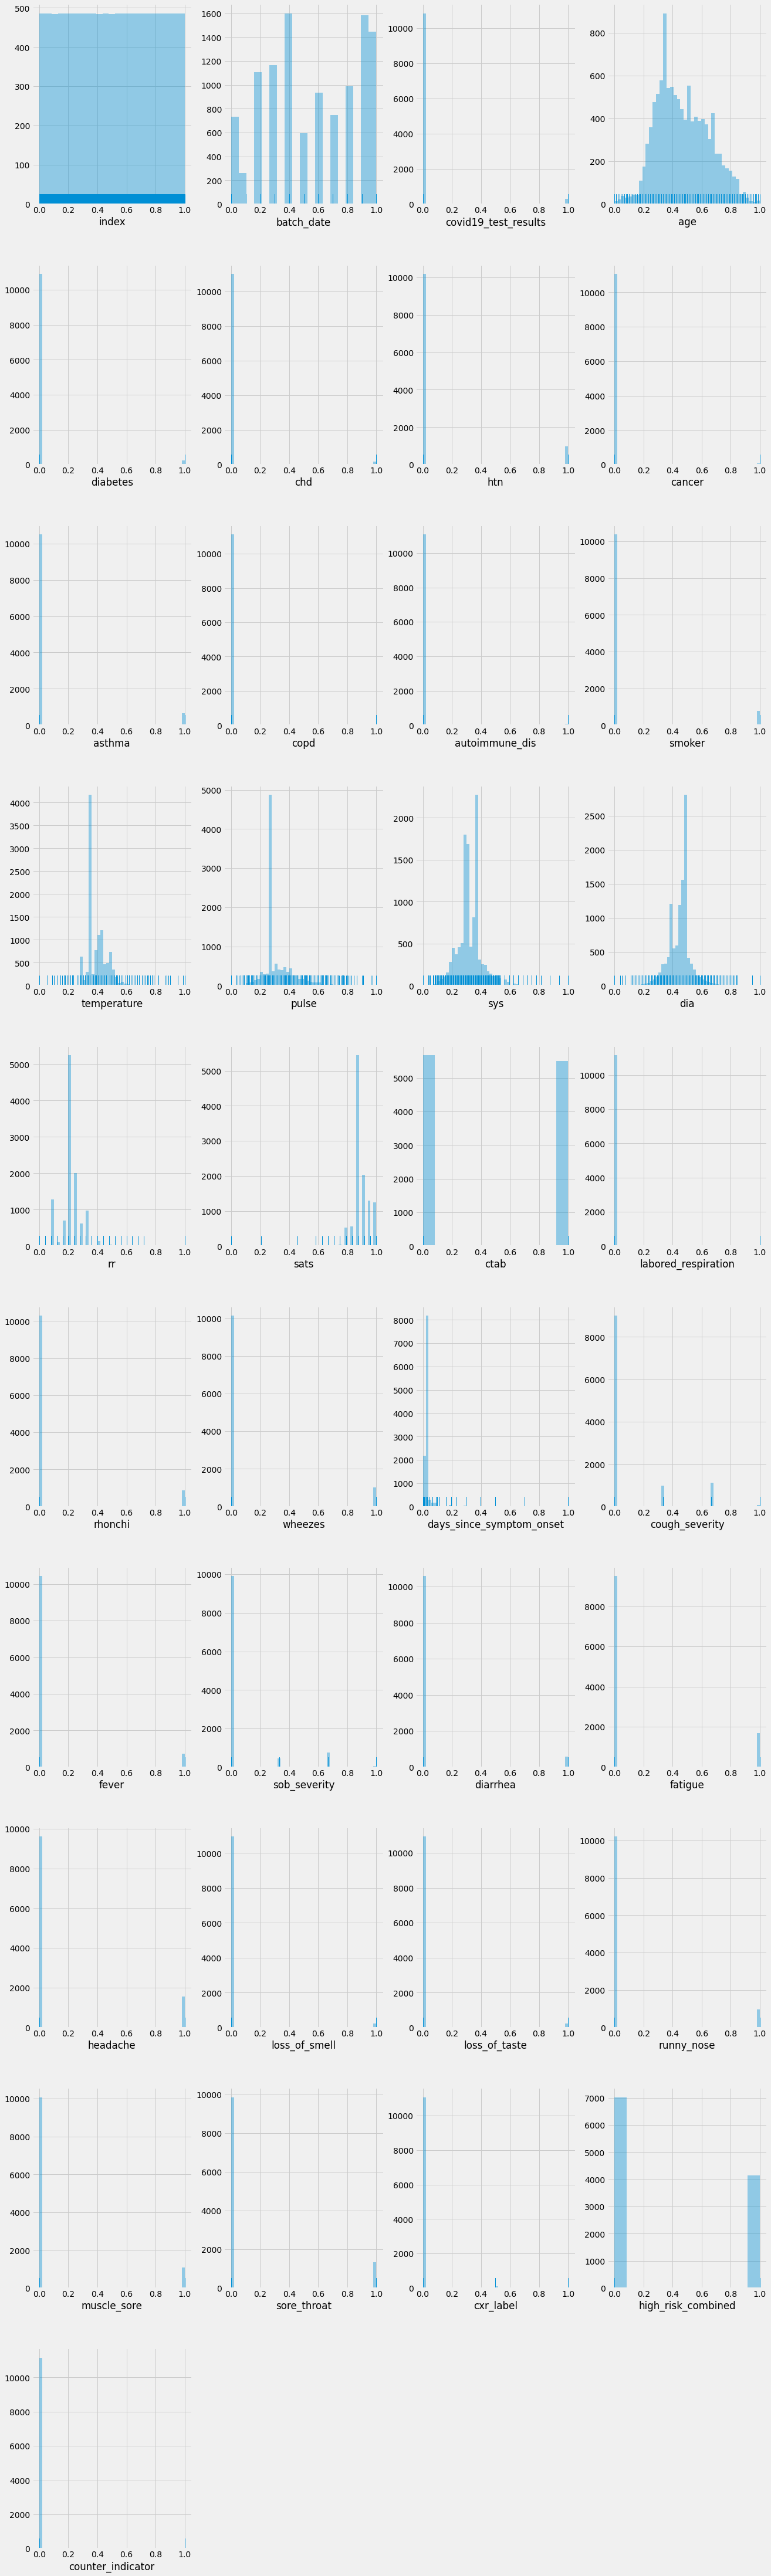

In [9]:
da.plotDataDistributions(df)